In [31]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

with open("experiment_data_with_hr.json", "r", encoding="utf-8") as f:
    participants = json.load(f)

# HR

## A. Plot heart rate over the entire experiment (one participant)

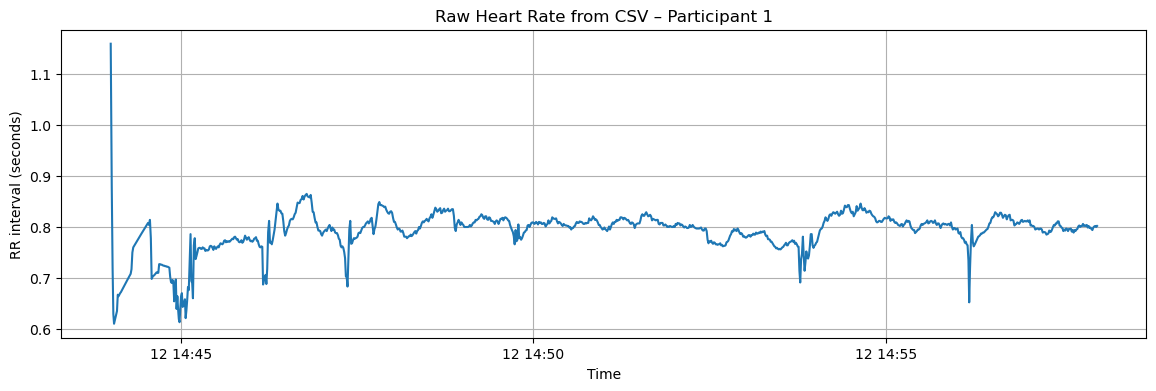

In [32]:
# -------- 1) helper: read raw HR CSV --------
def load_hr_file(path: str) -> pd.DataFrame:
    """
    Load a participantN.csv HR file into a DataFrame with:
    RR, ArtifactCorrectedRR, RawArtifact, ts
    """
    lines = Path(path).read_text(encoding="utf-8").splitlines()

    # find header line (the one containing RR and ts)
    header_idx = None
    for i, line in enumerate(lines):
        if "RR" in line and "ts" in line:
            header_idx = i
            break
    if header_idx is None:
        raise ValueError(f"Could not find header with 'RR' and 'ts' in {path}")

    header_line = lines[header_idx].strip()

    # detect delimiter
    if ";" in header_line and "," not in header_line:
        delim = ";"
    else:
        delim = ","

    header = [h.strip() for h in header_line.split(delim)]

    # data rows
    data_rows = []
    for line in lines[header_idx + 1 :]:
        if not line.strip():
            continue
        parts = [p.strip() for p in line.split(delim)]
        if len(parts) != len(header):
            continue
        data_rows.append(parts)

    df = pd.DataFrame(data_rows, columns=header)

    # numeric columns
    for col in ["RR", "ArtifactCorrectedRR", "RawArtifact"]:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    if "RawArtifact" in df.columns:
        df["RawArtifact"] = df["RawArtifact"].fillna(0).astype(int)

    if "ts" in df.columns:
        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")

    df = df.dropna(subset=["ts", "ArtifactCorrectedRR"])
    return df

# -------- 2) plot raw HR from CSV (no video cutting) --------
def plot_raw_hr_csv(participant_id: int):
    path = f"../trials_hr/participant{participant_id}.csv"  # adjust folder if needed
    df = load_hr_file(path)

    df["RR_seconds"] = df["ArtifactCorrectedRR"] / 1000.0

    plt.figure(figsize=(14, 4))
    plt.plot(df["ts"], df["RR_seconds"], linestyle="-")
    plt.title(f"Raw Heart Rate from CSV – Participant {participant_id}")
    plt.xlabel("Time")
    plt.ylabel("RR interval (seconds)")
    plt.grid(True)
    plt.show()
plot_raw_hr_csv(1)


## B. Plot heart rate per video

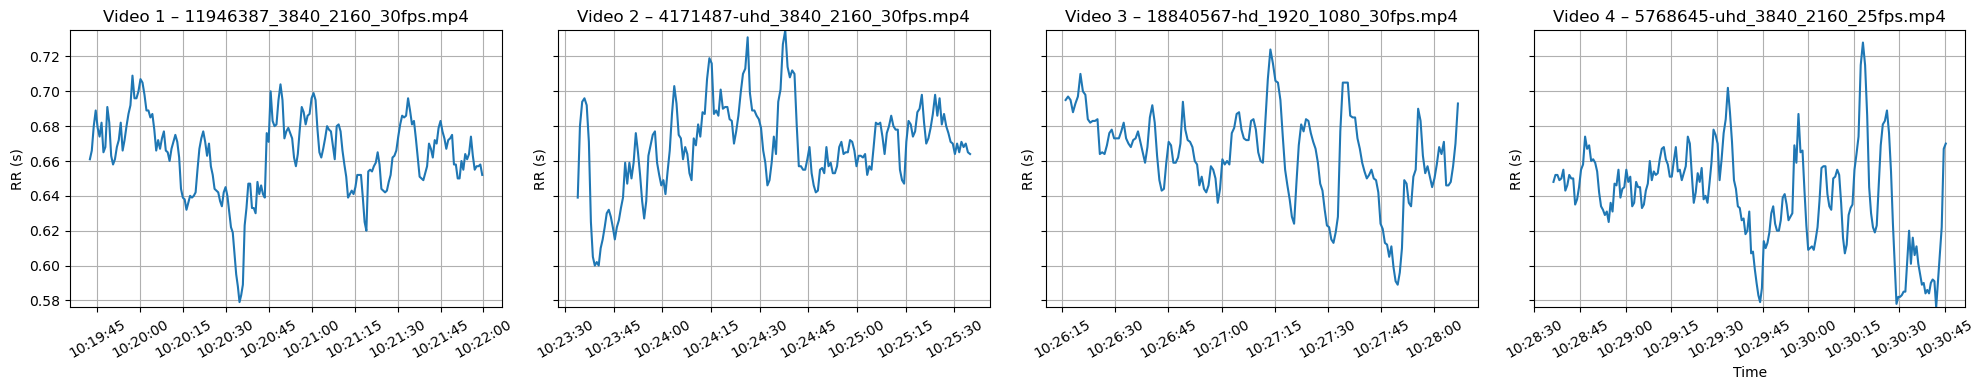

In [47]:
def plot_hr_by_video(participant_id):
    p = next(pp for pp in participants if pp["participant_id"] == participant_id)
    n = len(p["stimuli"])
    if n == 0:
        print("No stimuli for this participant")
        return

    # compute global y-limits
    mins, maxs = [], []
    for stim in p["stimuli"]:
        dfh = pd.DataFrame(stim.get("heart_rate", []))
        if "ArtifactCorrectedRR" in dfh.columns and not dfh.empty:
            vals = pd.to_numeric(dfh["ArtifactCorrectedRR"], errors="coerce") / 1000.0
            mins.append(vals.min()); maxs.append(vals.max())
    ymin, ymax = (min(mins), max(maxs)) if mins else (0, 1)

    fig, axes = plt.subplots(1, n, figsize=(5 * n, 4), sharey=True)
    if n == 1:
        axes = [axes]

    for stim, ax in zip(p["stimuli"], axes):
        df = pd.DataFrame(stim.get("heart_rate", []))
        if df.empty or "ts" not in df.columns or "ArtifactCorrectedRR" not in df.columns:
            ax.text(0.5, 0.5, "No HR data", ha="center", va="center", transform=ax.transAxes)
            ax.set_title(f"Video {stim['id']} – {stim.get('video_id','')}")
            ax.grid(True)
            ax.set_ylim(ymin, ymax)
            continue

        df["ts"] = pd.to_datetime(df["ts"], errors="coerce")
        df["RR_seconds"] = pd.to_numeric(df["ArtifactCorrectedRR"], errors="coerce") / 1000.0
        df = df.dropna(subset=["ts", "RR_seconds"]).sort_values("ts")

        ax.plot(df["ts"], df["RR_seconds"], linestyle="-")
        ax.set_title(f"Video {stim['id']} – {stim['video_id']}")
        ax.set_ylabel("RR (s)")
        ax.grid(True)
        ax.set_ylim(ymin, ymax)
        for lbl in ax.get_xticklabels():
            lbl.set_rotation(30)

    axes[-1].set_xlabel("Time")
    fig.tight_layout()
    plt.show()

plot_hr_by_video(13)


## C. Plot whole experiment with video boundaries

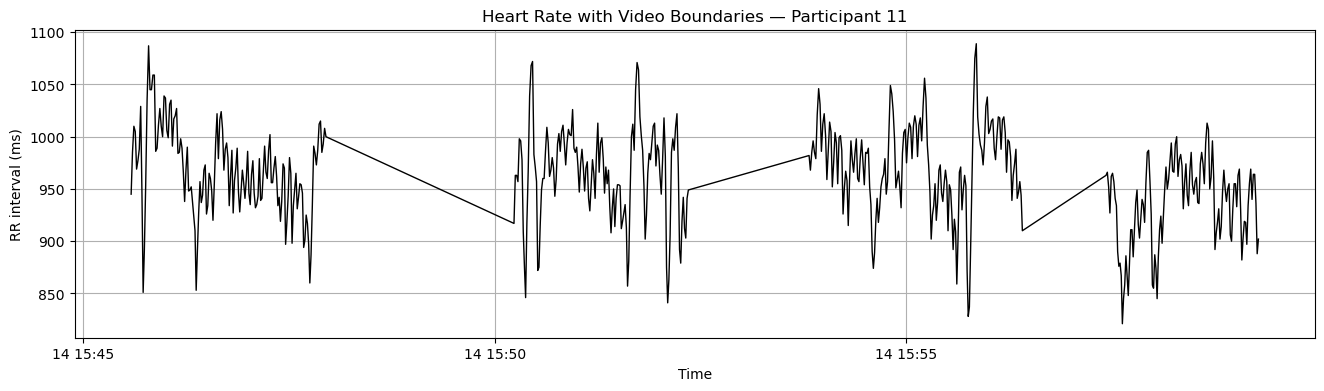

In [ ]:
def plot_hr_with_videos(participant_id):
    p = next(pp for pp in participants if pp["participant_id"] == participant_id)
    rows = []
    for stim in p["stimuli"]:
        rows.extend(stim.get("heart_rate", []))
    df = pd.DataFrame(rows)
    if df.empty:
        print("No HR data"); return

    # prefer ArtifactCorrectedRR, fallback to RRs
    if "ArtifactCorrectedRR" in df.columns:
        df["RR_ms"] = pd.to_numeric(df["ArtifactCorrectedRR"], errors="coerce")
    else:
        df["RR_ms"] = pd.to_numeric(df.get("RR"), errors="coerce")

    # robust timestamp parsing for mixed formats
    df["ts"] = pd.to_datetime(df["ts"].astype(str), errors="coerce")
    df = df.dropna(subset=["ts", "RR_ms"]).sort_values("ts")

    plt.figure(figsize=(16, 4))
    plt.plot(df["ts"], df["RR_ms"], color="black", linewidth=1, label="RR (ms)")

    ymax = df["RR_ms"].max()
    for stim in p["stimuli"]:
        start = stim.get("video_start")
        end = stim.get("video_end")
        if start:
            s = pd.to_datetime(str(start), errors="coerce")
            if pd.notna(s):
                plt.axvline(s, color="green", linestyle="--", alpha=0.7)
                plt.text(s, ymax, f"Video {stim.get('id')}", rotation=90, verticalalignment="top")
        if end:
            e = pd.to_datetime(str(end), errors="coerce")
            if pd.notna(e):
                plt.axvline(e, color="red", linestyle="--", alpha=0.7)

    plt.title(f"Heart Rate with Video Boundaries — Participant {participant_id}")
    plt.xlabel("Time")
    plt.ylabel("RR interval (ms)")
    plt.grid(True)
    plt.show()

plot_hr_with_videos(11)

## Plot raincloud of the overall RMSSD values

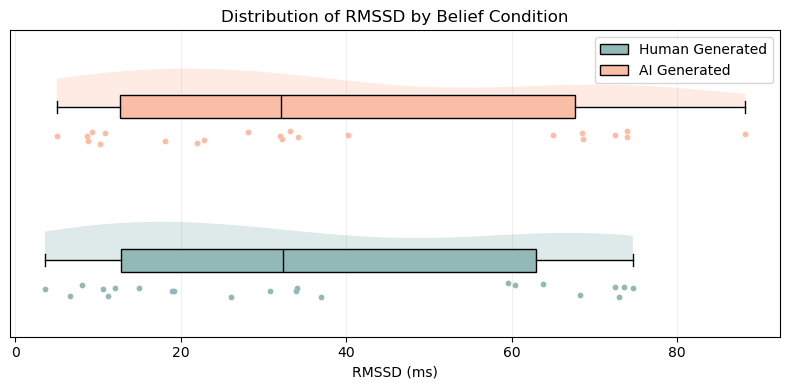

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

mean_table = pd.read_csv('rmssd_per_participant.csv')

## Distribution of data (raincloud)
# Helper function to hide the top part of the violin plot and color them
def violin_to_distribution(vp, colors):
    for idx, b in enumerate(vp['bodies']):
        # Modify it so we only see the upper half of the violin plot
        b.get_paths()[0].vertices[:, 1] = np.clip(b.get_paths()[0].vertices[:, 1], idx+1, idx+2)
        # Change the color
        b.set_facecolor(colors[idx])

# Data to plot
data = [mean_table['AI Generated'], mean_table['Human Generated']]
colors = ["#92B9B8", "#FABEA6"]

fig, ax = plt.subplots(figsize=(8,4))

# Plot boxplot
bp = ax.boxplot(data, patch_artist=True, vert=False)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color('black')
ax.set_yticks([])

# Plot distribution (violin plot)
vp = ax.violinplot(data, points = 500, showmeans=False, showextrema=False, showmedians=False, vert=False); 
violin_to_distribution(vp, colors)

# Plot individual points (scatter plot)
for idx, features in enumerate(data):
    y = np.full(len(features), idx + .8)    # Move the points below the other plots
    idxs = np.arange(len(y))
    y = y.astype(float)
    y.flat[idxs] += np.random.uniform(low=-.05, high=.05, size=len(idxs))
    plt.scatter(features, y, s=10, c=colors[idx])

plt.xlabel('RMSSD (ms)')
plt.grid(True, alpha=0.2, axis='x')
plt.title('Distribution of RMSSD by Belief Condition')
plt.legend(['Human Generated', 'AI Generated'], loc='upper right')
plt.tight_layout()
plt.show()

# SAM
- Boxplot for SAM, focus and attitude
- Wordcloud for freetext
- Fix plot in data analysis preliminar

## Plot boxplot for each SAM and belief

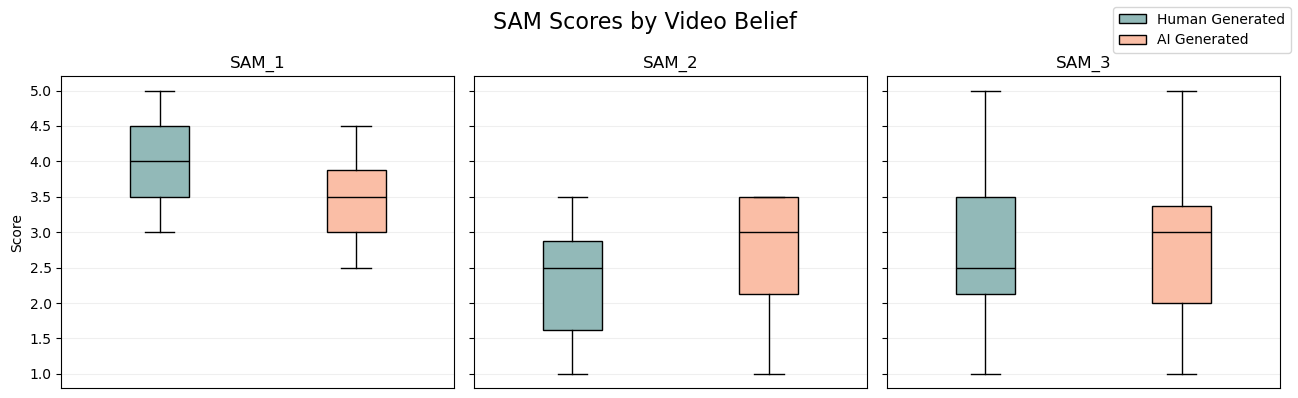

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

SAMS = ['SAM_1', 'SAM_2', 'SAM_3']
mean_table = pd.read_csv('sam_per_participant.csv', header=[0,1], index_col=0)

colors = ["#92B9B8", "#FABEA6"]

fig, axes = plt.subplots(1, 3, figsize=(13, 4), sharey=True)
for i, sam in enumerate(SAMS):
    ax = axes[i]
    data_to_plot = [mean_table[sam]['Human Generated'].dropna(), mean_table[sam]['AI Generated'].dropna()]
    bp = ax.boxplot(data_to_plot, patch_artist=True, widths=0.3)
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    for median in bp['medians']:
        median.set_color('black')
    ax.set_title(f'{sam}')
    ax.set_xticks([])
    ax.yaxis.grid(True, alpha=0.2)

fig.suptitle('SAM Scores by Video Belief', fontsize=16)
axes[0].set_ylabel('Score')
fig.legend(['Human Generated', 'AI Generated'], loc='upper right')
fig.tight_layout()
plt.show()


# Focus

## Plot boxplot of focus for each belief

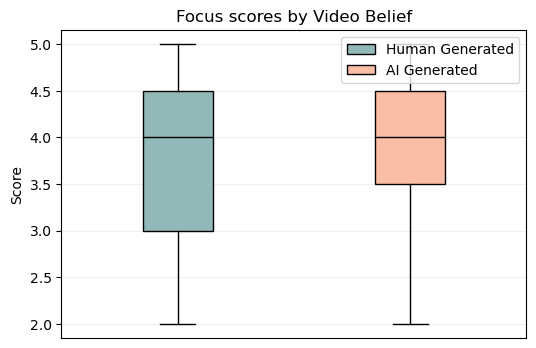

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

mean_table = pd.read_csv('focus_per_participant.csv')

colors = ["#92B9B8", "#FABEA6"]

plt.figure(figsize=(6, 4))
plt.title('Focus scores by Video Belief')

data = [mean_table['Human Generated'].dropna(), mean_table['AI Generated'].dropna()]
bp = plt.boxplot(data, patch_artist=True, widths=0.3)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
for median in bp['medians']:
    median.set_color('black')

plt.xticks([])
plt.ylabel('Score')
plt.grid(True, alpha=0.2, axis='y')
plt.legend(['Human Generated', 'AI Generated'], loc='upper right')
plt.show()


# Attitude

## Plot boxplot of attitude towards AI across all participant

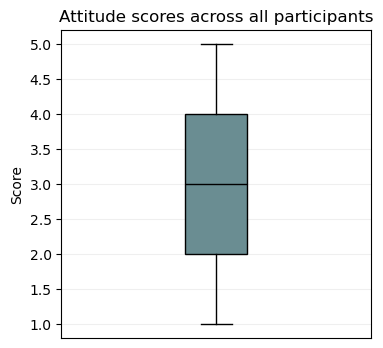

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

mean_table = pd.read_csv('attitude_per_participant.csv')

plt.figure(figsize=(4, 4))
plt.title('Attitude scores across all participants')

bp = plt.boxplot(mean_table["attitude"], patch_artist=True, widths=0.2)
bp['boxes'][0].set_facecolor("#6A8D92")  # muted teal to match palette
bp['medians'][0].set_color('black')

plt.xticks([])
plt.ylabel('Score')
plt.grid(True, alpha=0.2, axis='y')
plt.show()
